In [1]:
%matplotlib inline
import matplotlib, re
from matplotlib_venn import venn3, venn3_unweighted
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter

# Set the visualization settings
matplotlib.rcParams['axes.titlesize'] = 'xx-large'
matplotlib.rcParams['axes.labelsize'] = 'x-large'
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

In [2]:
#import ionbot hits
def read_df_in_chunks(filename, chunksize):
    # read the large csv file with specified chunksize 
    df_chunk = pd.read_csv(filename, chunksize=chunksize) # chunksize represents number of rows read per chunk

    chunk_list = []  # append each chunk df here 

    # Each chunk is in df format
    for chunk in df_chunk:  
        # perform data filtering 
        chunk_filter = chunk_preprocessing(chunk)

        # Once the data filtering is done, append the chunk to list
        chunk_list.append(chunk_filter)

    # concat the list into dataframe 
    df_concat = pd.concat(chunk_list) # this is your final dataframe
    
    return(df_concat)

def chunk_preprocessing(df_chunk):
    new_chunk=df_chunk[(df_chunk['ri_126.1277']>0) & (df_chunk['q_value']<=0.01) & (df_chunk['DB']=='T')]
    new_chunk=new_chunk[['scan_id','charge','precursor_mass','matched_peptide','modifications','ionbot_psm_score','DB','unexpected_modification','ms2pip_pearsonr','proteins','num_unique_pep_ids']]
    return(new_chunk)

ib_mutout_human=read_df_in_chunks('/data/data/spectra/identifications/ensembl_ref/ref_with_mutation/Linfeng_011011_HapMap35.mgf.ionbot.csv',1000)
ib_mutout_ont=read_df_in_chunks('/data/data/spectra/identifications/flair_only_with_mutation/Linfeng_011011_HapMap35.mgf.ionbot.csv',1000)
ib_mutout_human_ont=read_df_in_chunks('/data/data/spectra/identifications/ensembl_ref/ref_union_flair_with_mutation/Linfeng_011011_HapMap35.mgf.ionbot.csv',1000)


In [3]:
ib_mutout_human_ont.head()

,scan_id,charge,precursor_mass,matched_peptide,modifications,ionbot_psm_score,DB,unexpected_modification,ms2pip_pearsonr,proteins,num_unique_pep_ids
10,211,4,1636.943,NRPAIVRGAAGGGGR,0|[737]tmt6plex||6|mut,4.015,T,A->V,0.845,ENSP00000421592.2|ENST00000505490.2|ENSG000001...,16
11,53604,2,1347.695,QYNGVPLDGR,0|[737]tmt6plex||3|[7]deamidated[n],5.557,T,[7]deamidated[n],0.833,ENSP00000421592.2|ENST00000505490.2|ENSG000001...,16
13,111129,3,1653.871,MDMSLDDIIK,0|[737]tmt6plex||1|[35]oxidation[m]||10|[737]t...,5.244,T,NaN,0.906,ENSP00000421592.2|ENST00000505490.2|ENSG000001...,16
14,132008,3,3042.566,QYNGVPLDGRPMNIQLVTSQIDAQR,0|[737]tmt6plex||3|[7]deamidated[n],6.820,T,[7]deamidated[n],0.937,ENSP00000421592.2|ENST00000505490.2|ENSG000001...,16
15,45615,3,1613.852,AGSQGARGGGAQAAAR,0|[737]tmt6plex||6|mut,5.822,T,G->A,0.943,ENSP00000421592.2|ENST00000505490.2|ENSG000001...,16


In [29]:
#import the full list of coding transcripts
transcript_ids=[]
sources=['/data/data/genome_grch38/gencode.v29.pc_translations.fa','/data/data/spectra/dictionary/dumb_orfprediction_setA/flair.setA.final.pep']
for f in sources:
    with open(f) as handle:
        for line in handle:
            if line.startswith('>'):
                if ' ' in line.strip():
                    tid=line.split(' ')[0]
                    transcript_ids.append(tid[1:])
                else:
                    transcript_ids.append(line.strip()[1:])

In [33]:
transcript_ids[-4]

'40e46cba-b2f9-481c-ac11-e3dbda0e0276_ENSG00000264268.1|m.56242'

In [6]:
#check out coverage - general protein
proteins_covered=Counter()
for row in ib_mutout_human_ont.iterrows():
    protein=''
    if '||' in row[1][9]:
        ids=row[1][9].split('||')
        for idu in ids:
            proteins_covered[idu]+=1
    else:
        proteins_covered[row[1][9]]+=1
proteins_covered

Counter({'ENSP00000421592.2|ENST00000505490.2|ENSG00000183684.7|OTTHUMG00000160470.2|OTTHUMT00000360729.2|ALYREF-202|ALYREF|264': 49,
         'ENSP00000497923.1|ENST00000648640.1|ENSG00000162244.11|OTTHUMG00000155262.6|OTTHUMT00000500294.2|RPL29-210|RPL29|167': 27,
         'ENSP00000294189.4|ENST00000294189.10|ENSG00000162244.11|OTTHUMG00000155262.6|OTTHUMT00000349676.2|RPL29-201|RPL29|159': 27,
         'ENSP00000418868.1|ENST00000466397.5|ENSG00000162244.11|OTTHUMG00000155262.6|OTTHUMT00000349680.2|RPL29-202|RPL29|159': 27,
         'ENSP00000418153.1|ENST00000479017.5|ENSG00000162244.11|OTTHUMG00000155262.6|OTTHUMT00000349684.1|RPL29-204|RPL29|159': 27,
         'ENSP00000420673.1|ENST00000495383.5|ENSG00000162244.11|OTTHUMG00000155262.6|OTTHUMT00000349681.1|RPL29-209|RPL29|159': 27,
         'ENSP00000417048.1|ENST00000475248.5|ENSG00000162244.11|OTTHUMG00000155262.6|OTTHUMT00000349683.1|RPL29-203|RPL29|159': 27,
         'ENSP00000418346.1|ENST00000492277.5|ENSG00000162244.11|OT

In [44]:
sample=set(proteins_covered)
strange=sample.difference(set(transcript_ids))
uncovered=set(transcript_ids).difference(sample)
len(proteins_covered)

43081

In [54]:
#import the cpdt peptides- of the proteins that were found to have matches, store the peptides as counters in a data structure
cpdt='/data/data/spectra/insilico_digest/gencode.v29/gencode.v29.pc_translations.withheader.cpdt'
cpdt_pep={}
full_seqs={}
with open(cpdt) as c:
    add=False
    for line in c:
        if line.startswith('>'):
            key=line.strip()[1:]
            if key in set(proteins_covered):
                add=True
                cpdt_pep[key]={}
                full_seqs[key]
            else:
                add=False
        elif add and 'PEPTIDE' in line:
            lp=line.split('PEPTIDE ')[1]
            lp=lp.split(':')[0]
            cpdt_pep[key][lp]=0
        elif add and 'PEPTIDE' not in line:
            full_seqs[key]=line.strip()

In [55]:
#if the exprimental peptide is found to match the expected, add to the counter. if there is a mutation, do not count
list_mutated=set()
list_strange=set()
list_nohits=set()
#unmatched={}
unmatched=0
for row in ib_mutout_human_ont.iterrows():
    protein=''
    pep=row[1][3]
    mod=str(row[1][7])
    if '||' in row[1][9]:
        ids=row[1][9].split('||')
    else:
        ids=[row[1][9]]
    if '->' in mod:
        list_mutated.add(i for i in ids)
    for i in ids:
        found=False
        if i in cpdt_pep.keys():
            ispeplist=cpdt_pep[i]
            newpl=ispeplist #make copy to mutate as you iterate
            for p,ct in ispeplist.items():
                if p==pep:
                    ct+=1
                    newpl[p]=ct
                    found=True
            cpdt_pep[i]=newpl
            if '->' not in mod and found==False:
                list_strange.add(i)
        else:
            list_nohits.add(i)
        


In [102]:
#measure the horizontal and vertical coverage
#horizontal- go through the peptide dictionary i have, construct the sequence and calculate the percent of coverage
#exclude if less than 5 peptides
#save list of high-coverage proteins (vertical and horizontal- overlap?)
high_cov_vert={}
high_cov_hor={}
perc_cov_dist=[]
vert_cov=[]
for p,peps in cpdt_pep.items():
    seq=full_seqs[p]
    remains=seq
    count_pep=0
    for s,c in peps.items():
        if c>1: #increase this number with the whole dataset, "true" hit
            count_pep+=c
            if s in remains:
                remains=remains.replace(s,'')
            else:
                prefix=re.split('R|K',s)
                for p in prefix:
                    if len(p)>3 and p in remains:
                        remains=remains.replace(p,'')
    perc_cov=float((len(seq)-len(remains))/len(seq))*100
    perc_cov_dist.append(perc_cov)
    vert_cov.append(count_pep)
    if perc_cov>50:
        high_cov_hor[p]=peps
    if count_pep>100:
        high_cov_vert[p]=peps

(0, 600)

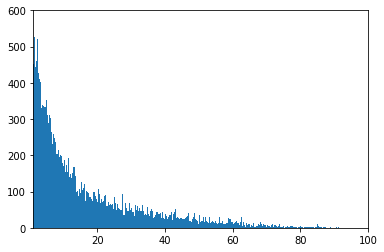

In [77]:
#percent sequence coverage
plt.hist(perc_cov_dist,bins=300)
plt.xlim(1,100)
plt.ylim(0,600)

In [100]:
print(len(high_cov_vert))

46


(array([2.268e+04, 3.510e+03, 1.731e+03, 1.019e+03, 7.010e+02, 4.240e+02,
        3.240e+02, 2.520e+02, 2.460e+02, 1.560e+02, 1.140e+02, 1.200e+02,
        1.140e+02, 8.800e+01, 8.600e+01, 7.600e+01, 6.100e+01, 5.100e+01,
        4.400e+01, 4.400e+01, 2.200e+01, 1.900e+01, 2.500e+01, 3.100e+01,
        2.600e+01, 1.700e+01, 1.300e+01, 2.200e+01, 6.000e+00, 1.200e+01,
        9.000e+00, 1.400e+01, 6.000e+00, 6.000e+00, 5.000e+00, 6.000e+00,
        1.100e+01, 7.000e+00, 1.000e+01, 4.000e+00, 6.000e+00, 1.800e+01,
        1.000e+00, 6.000e+00, 3.000e+00, 1.000e+00, 1.700e+01, 1.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 1.000e+01,
        1.000e+00, 3.000e+00, 3.000e+00, 5.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 7.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

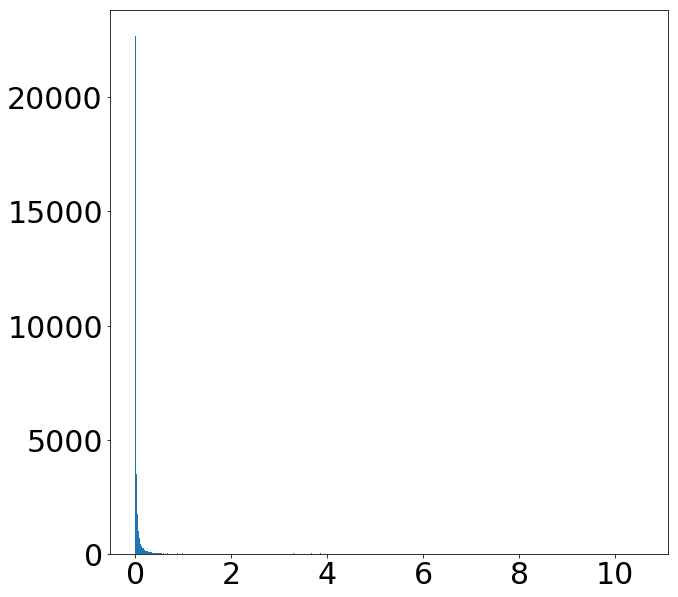

In [103]:
#peptides per protein (vertical coverage)
plt.hist(vert_cov,bins=500)
plt.xlim(1,100)

In [56]:
cpdt_pep['ENSP00000372819.3|ENST00000383329.7|ENSG00000204525.16|OTTHUMG00000031154.8|OTTHUMT00000258079.1|HLA-C-203|HLA-C|372']

{'MRVMAPR': 0,
 'MRVMAPRALLLLLSGGLALTETWACSHSMR': 0,
 'VMAPRALLLLLSGGLALTETWACSHSMR': 0,
 'ALLLLLSGGLALTETWACSHSMR': 0,
 'YFDTAVSR': 0,
 'YFDTAVSRPGR': 0,
 'YFDTAVSRPGRGEPR': 0,
 'PGRGEPR': 0,
 'PGRGEPRFISVGYVDDTQFVR': 0,
 'GEPRFISVGYVDDTQFVR': 0,
 'GEPRFISVGYVDDTQFVRFDSDAASPR': 0,
 'FISVGYVDDTQFVR': 10,
 'FISVGYVDDTQFVRFDSDAASPR': 0,
 'FISVGYVDDTQFVRFDSDAASPRGEPR': 0,
 'FDSDAASPR': 2,
 'FDSDAASPRGEPR': 0,
 'FDSDAASPRGEPRAPWVEQEGPEYWDR': 0,
 'GEPRAPWVEQEGPEYWDR': 0,
 'GEPRAPWVEQEGPEYWDRETQK': 0,
 'APWVEQEGPEYWDR': 5,
 'APWVEQEGPEYWDRETQK': 0,
 'APWVEQEGPEYWDRETQKYK': 0,
 'ETQKYK': 0,
 'ETQKYKR': 0,
 'YKRQAQADR': 0,
 'RQAQADR': 0,
 'RQAQADRVSLR': 0,
 'QAQADR': 0,
 'QAQADRVSLR': 0,
 'QAQADRVSLRNLR': 0,
 'VSLRNLR': 0,
 'VSLRNLRGYYNQSEDGSHTLQR': 0,
 'NLRGYYNQSEDGSHTLQR': 0,
 'NLRGYYNQSEDGSHTLQRMSGCDLGPDGR': 0,
 'GYYNQSEDGSHTLQR': 0,
 'GYYNQSEDGSHTLQRMSGCDLGPDGR': 0,
 'GYYNQSEDGSHTLQRMSGCDLGPDGRLLR': 0,
 'MSGCDLGPDGR': 2,
 'MSGCDLGPDGRLLR': 0,
 'MSGCDLGPDGRLLRGYDQSAYDGK': 0,
 'LLRGYDQSAYDGK

In [11]:
#number of above-threshold hits ont
len(ib_mutout_ont)

50647

In [12]:
#number of above-threshold hits reference
len(ib_mutout_human)

94642

In [19]:
#number of above-threshold hits reference + ont
len(ib_mutout_human_ont)

94022

In [19]:
#how many multiple mapped?
#number of unique proteins
d=ib_mutout_ont["proteins"]
count_mult=0
all_prots=set()
for prot in d:
    if '||' in prot:
        count_mult+=1
        prot=prot.split('||')
        for p in prot:
            all_prots.add(p)
    else:
        all_prots.add(prot)
print(len(all_prots))
print(count_mult)

23193
48185


In [41]:
#check if peptide come from same gene or matched to multiple
from collections import Counter
def parse_prots(list_prots):
    gl=set()
    for p in list_prots:
        if '_EN' in p:
            if '|m.' in p:
                p=p.split('|')[0]
            pl=p.split('_')[1]
            pl=pl.split('-')[0]
            gl.add(pl)
        else:
            pl=p.split('|')
            for ele in pl:
                if 'ENSG' in ele:
                    gl.add(ele)
                    break
    return(gl)

def parse_transcript(list_prots):
    '''if only 1 gene found from parse prots, how many different transcripts?'''
    gl=set()
    for p in list_prots:
        if '_EN' in p:
            if '|m.' in p:
                p=p.split('|')[0]
            pl=p.split('_')[0]
            gl.add(pl)
        else:
            pl=p.split('|')
            for ele in pl:
                if 'ENST' in ele:
                    gl.add(ele)
                    break
    return(gl)

count_single=0
count_double=0
count_multi=0
ct=Counter()
d=ib_mutout_human_ont["proteins"]
for prot in d:
    if '||' in prot:
        prot=prot.split('||')
        genelist=parse_prots(prot)
        if len(genelist)==1:
            count_single+=1
            trlist=parse_transcript(prot)
            ct[len(trlist)]+=1
        elif len(genelist)==2:
            count_double+=1
        elif len(genelist)>2:
            count_multi+=1
print(count_single, count_double, count_multi)
print(ct.most_common(10))

62060 12487 8594
[(2, 11212), (3, 10623), (4, 9013), (5, 7143), (6, 5192), (7, 3679), (8, 3293), (9, 2381), (10, 1507), (11, 1271)]


In [ ]:
#check if peptide match (in case of both ont and transcript) match to same gene

In [10]:
d=ib_mutout_human_ont["proteins"].head(1)
d.iloc[0]
#d.iloc[1]

'ENSP00000421592.2|ENST00000505490.2|ENSG00000183684.7|OTTHUMG00000160470.2|OTTHUMT00000360729.2|ALYREF-202|ALYREF|264'

In [51]:
ib_mutout_human_ont.head()

,scan_id,charge,precursor_mass,matched_peptide,modifications,ionbot_psm_score,DB,unexpected_modification,ms2pip_pearsonr,proteins,...,percolator_psm_score,q_value,PEP,ri_126.1277,ri_127.1311,ri_128.1344,ri_129.1378,ri_130.1411,ri_131.1382,title
10,211,4,1636.943,NRPAIVRGAAGGGGR,0|[737]tmt6plex||6|mut,4.015,T,A->V,0.845,ENSP00000421592.2|ENST00000505490.2|ENSG000001...,...,0.914,0.001,0.004,4485.211,3463.388,4170.723,3324.770,5085.466,4119.196,"Linfeng_011011_HapMap35_10.746.746.4 File:""Lin..."
11,53604,2,1347.695,QYNGVPLDGR,0|[737]tmt6plex||3|[7]deamidated[n],5.557,T,[7]deamidated[n],0.833,ENSP00000421592.2|ENST00000505490.2|ENSG000001...,...,1.930,0.000,0.000,13493.468,11478.784,12715.669,11120.964,15806.749,12475.679,"Linfeng_011011_HapMap35_3.9565.9565.2 File:""Li..."
13,111129,3,1653.871,MDMSLDDIIK,0|[737]tmt6plex||1|[35]oxidation[m]||10|[737]t...,5.244,T,NaN,0.906,ENSP00000421592.2|ENST00000505490.2|ENSG000001...,...,0.148,0.006,0.119,11922.566,17945.445,14594.153,14752.497,12632.057,10176.357,"Linfeng_011011_HapMap35_6.19692.19692.3 File:""..."
14,132008,3,3042.566,QYNGVPLDGRPMNIQLVTSQIDAQR,0|[737]tmt6plex||3|[7]deamidated[n],6.820,T,[7]deamidated[n],0.937,ENSP00000421592.2|ENST00000505490.2|ENSG000001...,...,3.317,0.000,0.000,11028.458,15392.277,24423.994,15567.110,32967.141,27598.090,"Linfeng_011011_HapMap35_7.19011.19011.3 File:""..."
15,45615,3,1613.852,AGSQGARGGGAQAAAR,0|[737]tmt6plex||6|mut,5.822,T,G->A,0.943,ENSP00000421592.2|ENST00000505490.2|ENSG000001...,...,1.215,0.000,0.002,1279.255,1837.244,2240.035,1741.897,2058.141,1544.578,"Linfeng_011011_HapMap35_3.673.673.3 File:""Linf..."


In [5]:
#unique protein hits
#ib_mutout_human['proteins'].nunique()
ib_mutout_human_ont['proteins'].nunique()
#ib_mutout_ont['proteins'].nunique()

11748

In [59]:
#how many unique proteins were identified from the ONT translated proteome
ont_hits_combined['proteins'].nunique() 
#about half of the proteome found with the combined dictionary were attributed to the ont translated proteome!!


7035

In [11]:
#how many hits required a single amino acid substitution in each of the search dictionaries
modhit_human_ont=ib_mutout_human_ont.dropna(subset=['unexpected_modification'])
#len(modhit_human_ont) #number of hits with modificaiotn
muthit_human_ont=modhit_human_ont[modhit_human_ont['unexpected_modification'].str.contains('->')]
#len(muthit_human_ont) #nubmer of hits with mutation
muthit_human_ont['proteins'].nunique() #number of unique proteins that had a mutated peptide detected

752

In [81]:
#venn diagram multiple mapping the combination set
ref_only=set()
ont_only=set()
ont_only_prot={}
both=set()
for row in ib_mutout_human_ont.iterrows():
    if '||' in row[1][9]:
        ids=row[1][9].split('||')
        ont=False
        ref=False
        for i in ids:
            if '|m.' in i:
                ont=True
            else:
                ref=True
        if ont and ref:
            both.add(row[1][0])
        elif ont:
            ont_only.add(row[1][0])
            ont_only_prot[row[1][0]]=row[1][9]
        elif ref:
            ref_only.add(row[1][0])
        else:
            print('AHHHHH')
            break
    else:
        if 'HUMAN' in (row[1][9]):
            ref_only.add(row[1][0])
        else:
            ont_only.add(row[1][0])
print(len(ont_only))
            

10942


In [82]:
#compare_combi_ref=pd.DataFrame()
compare_combi_ref_matched=pd.DataFrame()
compare_combi_ref_unmatched=pd.DataFrame()
count=0
for sid in both:
    #count+=1
    #if count > 1000:
    #    break
    if sid in ib_mutout_human['scan_id'].tolist():
        row=ib_mutout_human[ib_mutout_human['scan_id']==sid]
        row2=ib_mutout_human_ont[ib_mutout_human_ont['scan_id']==sid]
        #rownew=row.merge(row2,left_on='scan_id',right_on='scan_id')
        p_h=ib_mutout_human.loc[ib_mutout_human['scan_id']==sid,'proteins']
        p_h=p_h.iloc[0]
        p_oh=ib_mutout_human_ont.loc[ib_mutout_human_ont['scan_id']==sid,'proteins']
        p_oh=p_oh.iloc[0]
        if p_h in p_oh:
            compare_combi_ref_matched=compare_combi_ref_matched.append(row)
            compare_combi_ref_matched=compare_combi_ref_matched.append(row2)
        else:
            compare_combi_ref_unmatched=compare_combi_ref_unmatched.append(row)
            compare_combi_ref_unmatched=compare_combi_ref_unmatched.append(row2)
        #compare_combi_ref=compare_combi_ref.append(row)
        #compare_combi_ref=compare_combi_ref.append(row2)

KeyboardInterrupt: 

In [21]:
len(compare_combi_ref_unmatched)/2

819.0

In [86]:
both

{131076,
 131086,
 131096,
 131101,
 131107,
 131110,
 131115,
 131121,
 131123,
 131134,
 131140,
 131141,
 131146,
 131148,
 131152,
 131160,
 131163,
 131165,
 131170,
 131175,
 131178,
 131179,
 131180,
 131182,
 131185,
 131190,
 131191,
 131192,
 131193,
 131196,
 131198,
 131202,
 138,
 131215,
 131216,
 131217,
 131220,
 131222,
 131224,
 131225,
 131228,
 131232,
 131235,
 131236,
 131240,
 131241,
 131243,
 175,
 131251,
 131255,
 183,
 131259,
 188,
 131264,
 131268,
 131273,
 131279,
 131282,
 131283,
 131284,
 131290,
 131293,
 131295,
 131299,
 131305,
 131307,
 131311,
 131317,
 131318,
 131326,
 131327,
 131332,
 131338,
 131342,
 131343,
 131344,
 131346,
 131348,
 131352,
 285,
 131368,
 131383,
 131385,
 131387,
 131388,
 131391,
 131397,
 131404,
 131417,
 131418,
 131423,
 131432,
 131433,
 131434,
 360,
 131436,
 131435,
 368,
 131451,
 131452,
 381,
 131458,
 131459,
 131466,
 131472,
 131473,
 131488,
 131490,
 131494,
 131499,
 428,
 131504,
 131506,
 131507,
 

In [12]:
p=ib_mutout_human_ont.loc[ib_mutout_human_ont['scan_id']==10702,'proteins']
p.iloc[0]

IndexError: single positional indexer is out-of-bounds

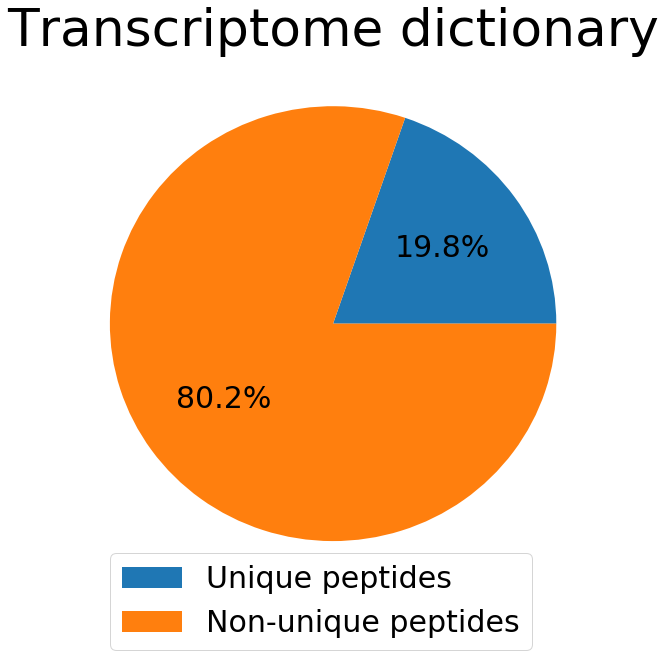

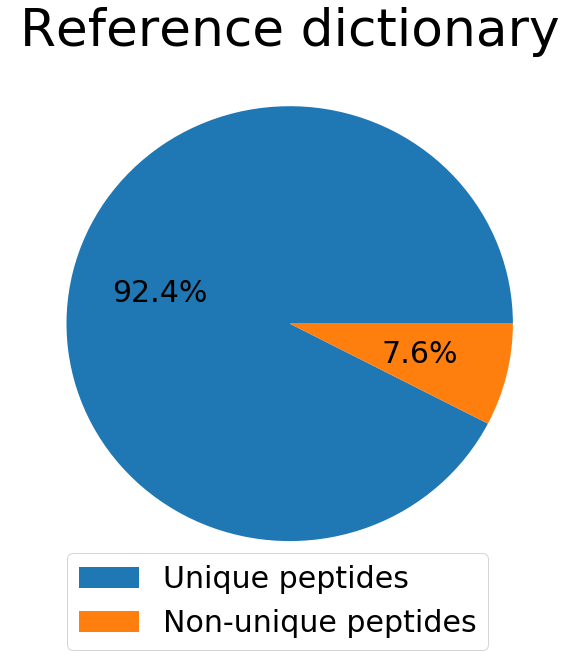

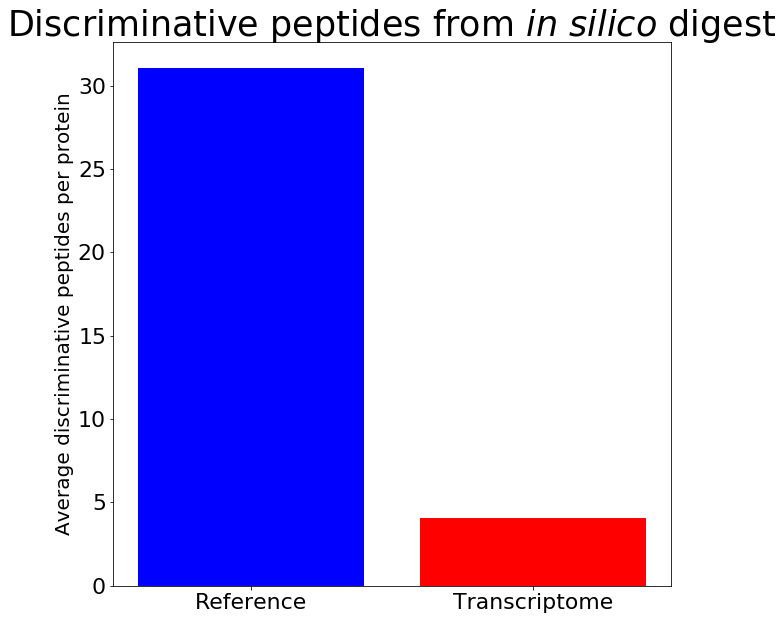

In [318]:
#plot for in silico digest
matplotlib.rcParams['axes.titlesize'] = 'xx-large'
matplotlib.rcParams['axes.labelsize'] = 'x-large'
matplotlib.rcParams['font.size'] = 30
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
labels='Unique peptides','Non-unique peptides'
plt.figure(0)
plt.pie([202437,1024117-202437], autopct='%1.1f%%')
plt.title('Transcriptome dictionary')
plt.legend(labels,loc = (0.1,-0.1))
plt.figure(1)
plt.pie([654057,707890-654057], autopct='%1.1f%%')
plt.title('Reference dictionary')
plt.legend(labels,loc = (0.1,-0.1))
plt.figure(2)
discriminative_ref=510708/16446
discriminative_ont=61942/15136
n_groups = 2
index = np.arange(n_groups)
bar_width = 0.35
plt.bar(index,[discriminative_ref,discriminative_ont],tick_label=['Reference','Transcriptome'],color=['b','r'])
plt.tick_params(labelsize=22)
plt.ylabel('Average discriminative peptides per protein',fontsize=20)
plt.title('Discriminative peptides from $\it{in}$ $\it{silico}$ digest',fontsize=35)
plt.show()

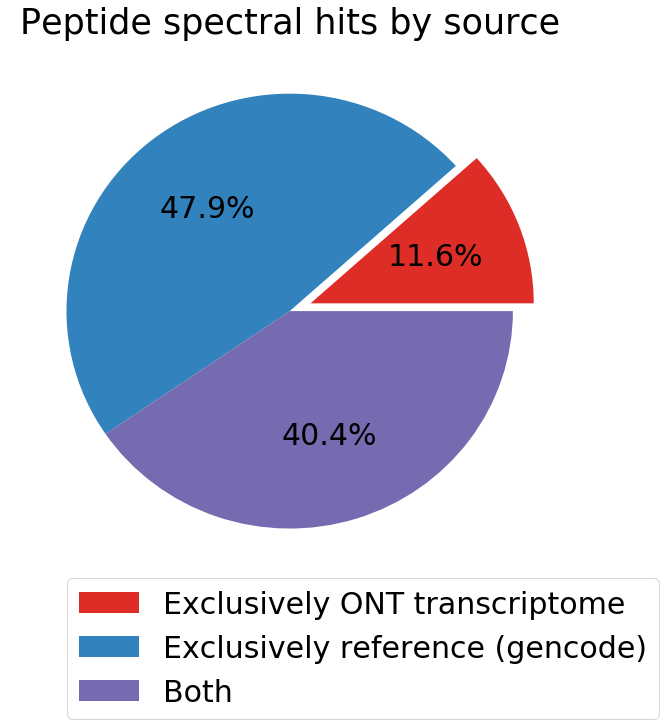

In [91]:
matplotlib.rcParams['axes.titlesize'] = 'xx-large'
matplotlib.rcParams['axes.labelsize'] = 'x-large'
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams['font.size'] = 30
explode = (0.1, 0, 0)
labels='Exclusively ONT transcriptome','Exclusively reference (gencode)', 'Both'
plt.pie([len(ont_only),len(ref_only),len(both)],autopct='%1.1f%%', explode=explode,colors=['#de2d26','#3182bd','#756bb1'])
plt.title('Peptide spectral hits by source',fontsize=35)
plt.legend(labels,loc = (0.1,-0.25))
plt.show()


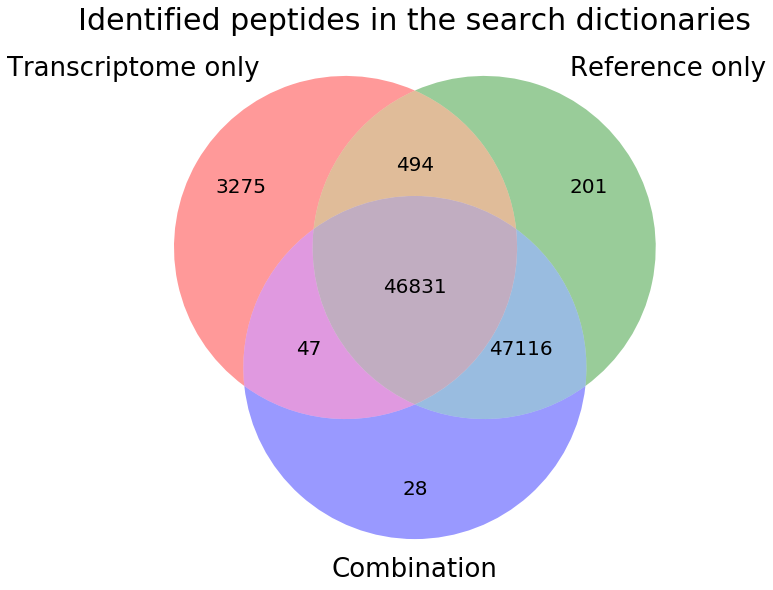

In [25]:
matplotlib.rcParams['axes.titlesize'] = 'xx-large'
matplotlib.rcParams['axes.labelsize'] = 'x-large'
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
matplotlib.rcParams['font.size'] = 30
prot_ont=set(ib_mutout_ont['scan_id'].tolist())
prot_ref=set(ib_mutout_human['scan_id'].tolist())
prot_ref_ont=set(ib_mutout_human_ont['scan_id'].tolist())
results_list=[prot_ont,prot_ref,prot_ref_ont]
results_union = set().union(*results_list)
total = len(results_union)
#vd=venn3_unweighted(results_list, ('Transcriptome only','Reference only', 'Combination'),subset_label_formatter=lambda x: f"{(x/total):0.01%}")
vd=venn3_unweighted(results_list, ('Transcriptome only','Reference only', 'Combination'))
plt.title("Identified peptides in the search dictionaries",fontsize=30)
for text in vd.set_labels:
    text.set_fontsize(26)
for text in vd.subset_labels:
    text.set_fontsize(20)
#vd.get_label_by_id('010').set_text('276 (0.2%)')
#vd.get_label_by_id('001').set_text('501 (0.0%)')
#vd.get_label_by_id('100').set_text('3275 (3.3%)')
#vd.get_label_by_id('011').set_text('47116 (48.1%)')
#vd.get_label_by_id('110').set_text('')
#vd.get_label_by_id('101').set_text('314 (0.0%)')
#vd.get_label_by_id('111').set_text('49705 (47.8%)')
plt.show()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


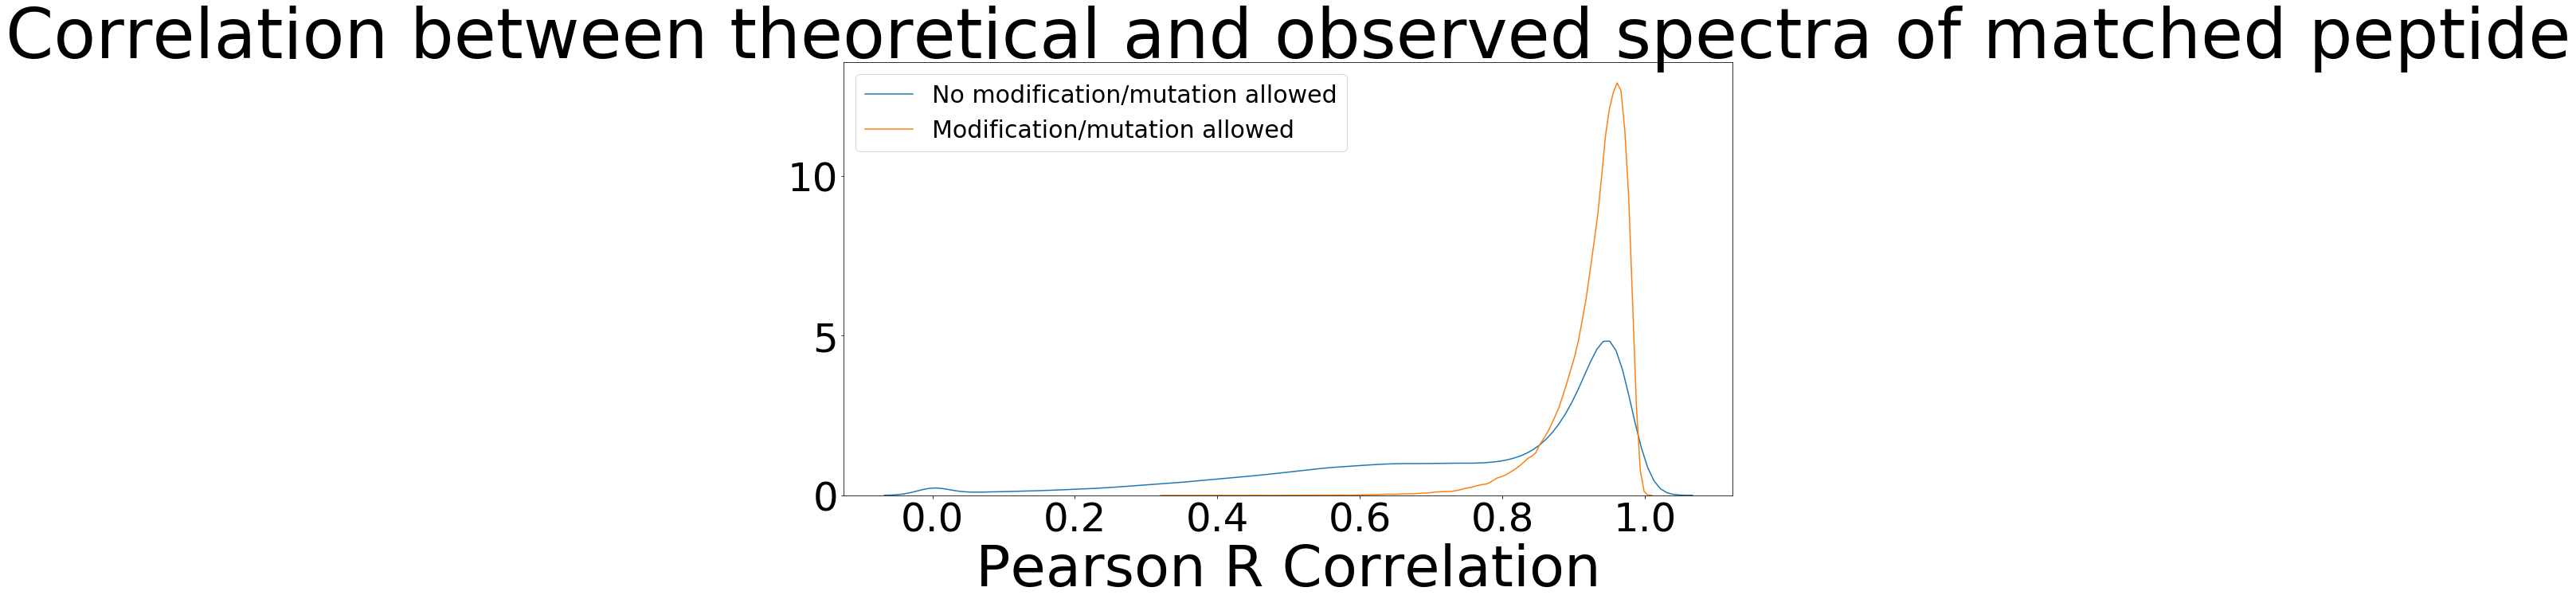

In [18]:
#plot score distributions comparing allowing mutation vs. not allowing mutation on human reference
plt.figure("Pearson R distribution")
matplotlib.rcParams['figure.figsize'] = (40.0, 20.0)
matplotlib.rcParams['font.size'] = 50
sns.distplot(ib_nomutout['ms2pip-pearsonr'], hist=False, label='No modification/mutation allowed',axlabel='Pearson R Correlation')
sns.distplot(ib_mutout_human['ms2pip_pearsonr'], hist=False, label='Modification/mutation allowed',axlabel='Pearson R Correlation')
#plt.legend(prop={'size':25})
#plt.tick_params(labelsize=22)
#plt.xlabel("Pearson R correlation",fontsize=22)
plt.legend(prop={'size':30})
plt.title('Correlation between theoretical and observed spectra of matched peptide')
plt.show()

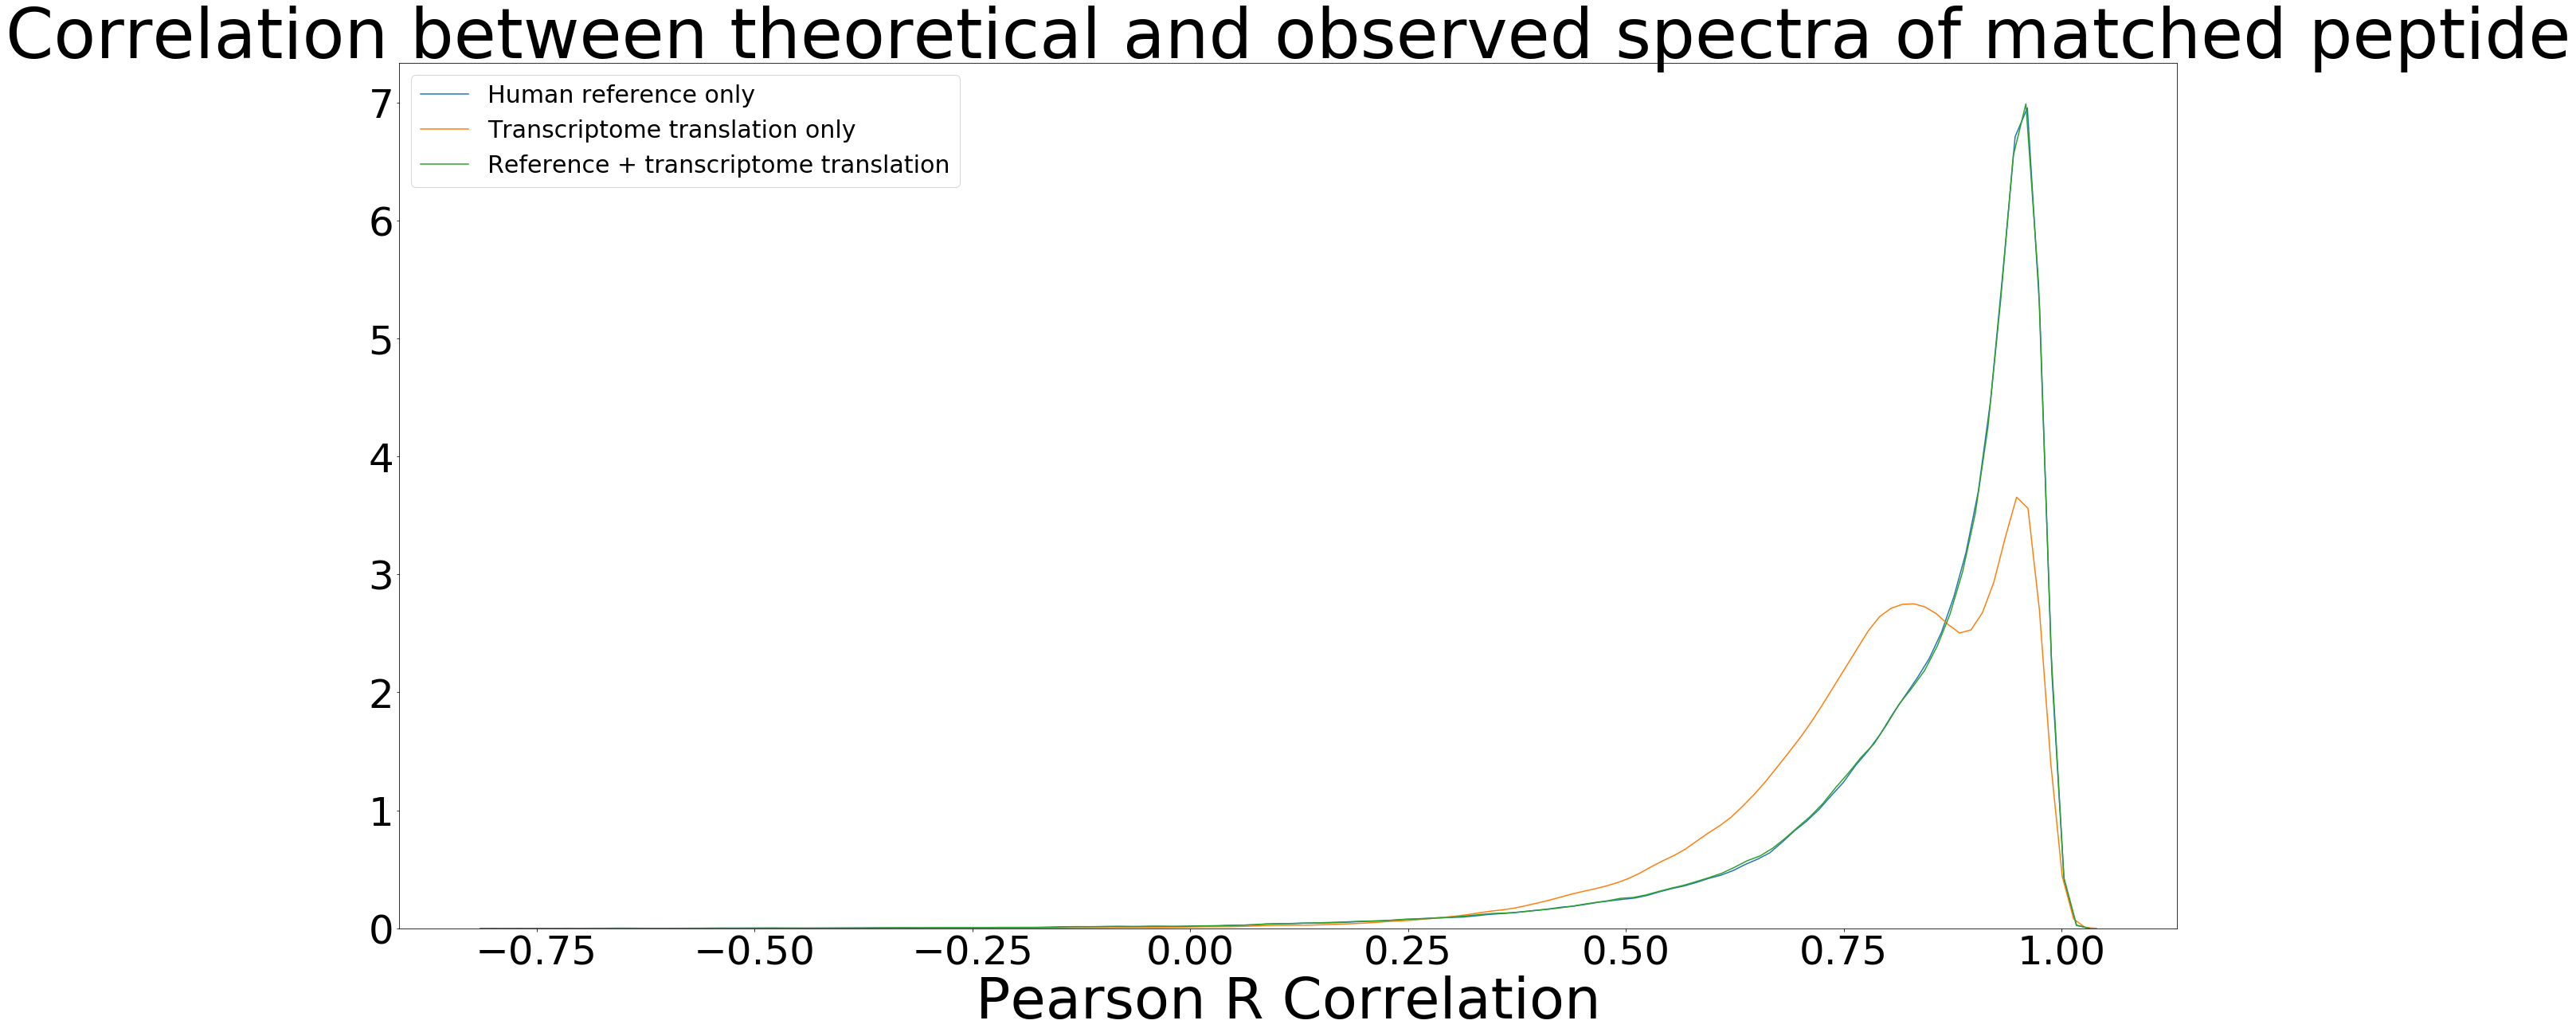

In [5]:
#plot score distributions from each of the spectral dictionaries
plt.figure("Pearson R distribution")
#matplotlib.rcParams['axes.titlesize'] = 'xx-large'
#matplotlib.rcParams['axes.labelsize'] = 'x-large'
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
sns.distplot(ib_mutout_human['ms2pip_pearsonr'], hist=False, label='Human reference only',axlabel='Pearson R Correlation')
sns.distplot(ib_mutout_ont['ms2pip_pearsonr'], hist=False, label='Transcriptome translation only',axlabel='Pearson R Correlation')
sns.distplot(ib_mutout_human_ont['ms2pip_pearsonr'], hist=False, label='Reference + transcriptome translation',axlabel='Pearson R Correlation')
plt.legend(prop={'size':30})
plt.title('Correlation between theoretical and observed spectra of matched peptide')
plt.show()